In [2]:
rm(list=ls())
library(refund);
library(ggplot2)
library(dplyr); 
library(dplyr); 
library(reshape2); 
library(fda);
set.seed(100)

# Table of contents: tbd

In [3]:
# set up "global" variables
n_obs = 60
n_var = 150 #number of vars
test = seq(1,20,1)
grid = seq(0, 1, length = n_var+1)
beta1 = sin(grid * 2 * pi)
beta2 = -dnorm(grid, mean=.2, sd=.03) +3*dnorm(grid, mean=.5,
sd=.04)+dnorm(grid, mean=.75, sd=.05)

nharm = 4 #number of fpc


In [4]:
data_generation <-function(){
var1 = 1
var2 = 5
var3 = 0.2

X <- matrix(0, nrow=n_obs, ncol=length(grid))
for(i2 in 1:n_obs){
    X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
    X[i2,]=X[i2,]+runif(1, 0, var2)
    X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
    
    for(j2 in 1:10){
        e =rnorm(2, 0, var1/j2^(2))
        X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
        X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
    }
    
}
return(X)
'
# This is a "more clear" setup

X <- matrix(0, nrow=n_obs, ncol=length(grid))
for(i2 in 1:n_obs){
    X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
    X[i2,]=X[i2,]+runif(1, 0, var2)
    X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
    
    e=abs(rnorm(2, 0, 1**(2)))
    X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid)
    X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid)
    
    
    
}
return(X)
'
}


[1] 151  60

[1] "done"

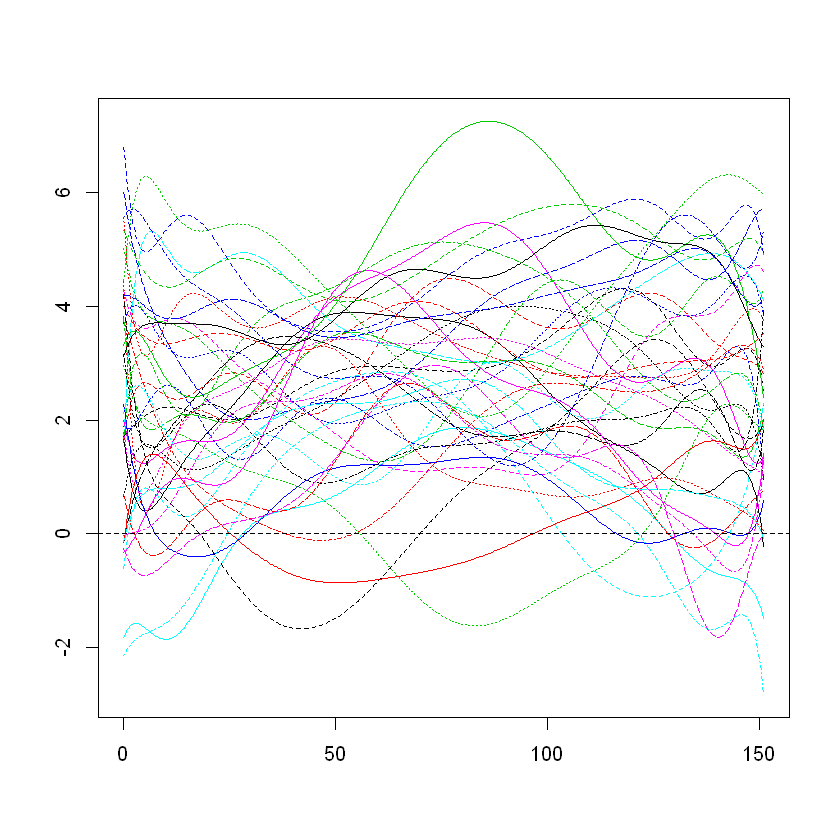

In [5]:
X = data_generation()
Y = X %*% beta1*(1/n_var)  + rnorm(n_obs, 0, 0.125) 
Y = as.numeric(Y)
final_X = t(X)
X_train = final_X[,-test]
Y_train = Y[-test]
X_test = final_X[,test]
Y_test = Y[test]
dim(final_X) # transpose, st obsverations now in columns // 
#todo: check if dim correct 

smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 12, 7)
harmFdpar = fdPar(smallbasis)

smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
smooth_basis_train_fd = smooth_basis_train$fd
smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
smooth_basis_test_fd = smooth_basis_test$fd

simulated_pcaObj_train = pca.fd(smooth_basis_train_fd, nharm = nharm, harmfdPar = harmFdpar, centerfns = FALSE)
simulated_pcaObj_test = pca.fd(smooth_basis_test_fd, nharm = nharm, harmfdPar = harmFdpar, centerfns = FALSE)
#simulated_pcaObj$varprop 
# todo:use to choose appropriate level of explained variance

plot(smooth_basis_train_fd, ylab="", xlab="",col="gray")

[1] "done"

[1] 0.5887043


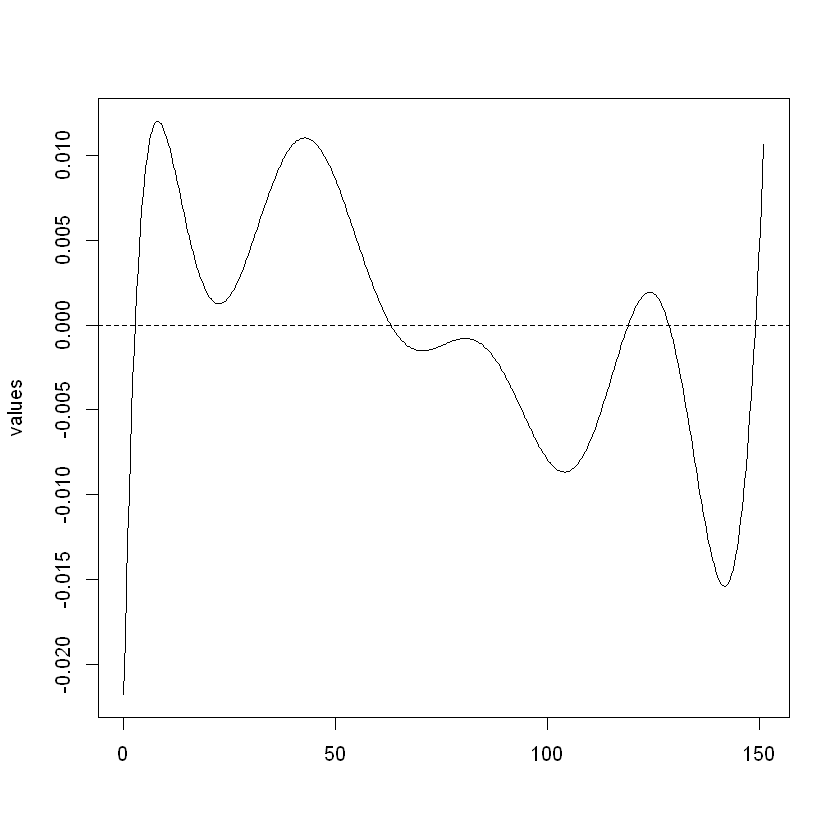

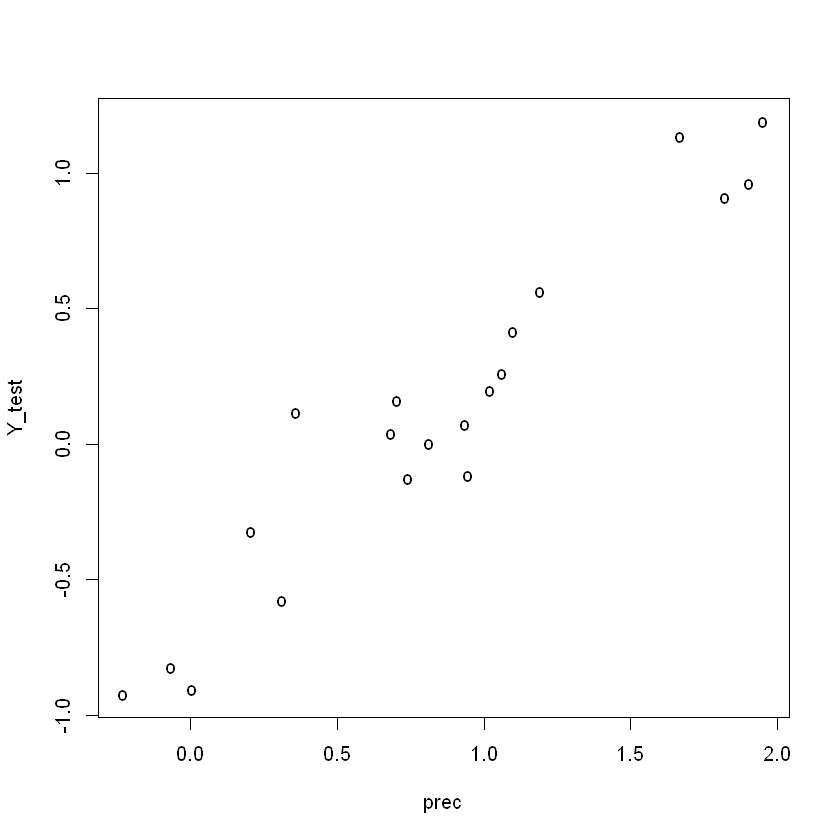

In [110]:
xfdlist = list(const=rep(1, (n_obs-length(test))), smooth_basis=smooth_basis_train_fd)
betabasis1 <- create.constant.basis(c(0, (n_obs-length(test))))
betabasis_test <- create.constant.basis(c(0, length(test)))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
betafd2    <- create.bspline.basis(rangeval = c(0, n_var+1), nbasis = 12, 7)
betafdPar2  <- fdPar(betafd2)
betalist <- list(const=betafdPar1, smooth_basis_fd=betafdPar2)

cMap = smooth_basis_train$y2cMap # a matrix that contains the linear transformation that takes the raw data values into the coefficients defining a smooth functional data object

f_regress <- fRegress(y = Y_train, xfdlist, betalist, y2cMap = cMap)

# also possible to use formula interface:
#f_regress2 <- fRegress(Y_train ~ smooth_basis_train_fd)
prec <- predict.fRegress(object = f_regress, 
                newdata = list(const = fd(matrix(rep(1, length(test)), 1, length(test)), betabasis_test), 
                               data = smooth_basis_test_fd))

# #  plot the data and the fit
plot(f_regress$betaestlist[[2]])
MSE_test <- mean((Y_test-prec)^2)
print(MSE_test)
plot(prec, Y_test, type="p", pch="o")


## Trying to calculate confidence intervals, but our models miss betastderrlist, which s needed to calculate fregress.stderr

## Tryto replicate from https://github.com/cran/fda/blob/master/demo/weatherANOVA.R line 62 ff

In [112]:
yhatfd = fd(f_regress$yhatfdobj)
argval = (0:n_var)+0.5
yhatmat    <- eval.fd(argval, yhatfd)
ymat       <- eval.fd(seq(0,n_var,1), smooth_basis_train_fd)
tempresmat <- ymat[,1:(n_obs-length(test))] - yhatmat[,1:(n_obs-length(test))]
SigmaE     <- var(t(tempresmat))

# #  plot covariance surface for errors

# par(mfrow=c(1,1))
# contour(SigmaE, xlab="Day", ylab="Day")
# lines(dayrange,dayrange,lty=4)

# #  plot standard deviation of errors

# par(mfrow=c(1,1), mar=c(5,5,3,2), pty="m", ask=F)
# stddevE <- sqrt(diag(SigmaE))
# plot(daytime, stddevE, type="l",
#      xlab="Day", ylab="Standard error (deg C)")

# #  Repeat regression, this time outputting results for
# #  confidence intervals

# stderrList <- fRegressStderr(fRegressList, tempy2cMap, SigmaE)

# betastderrlist <- stderrList$betastderrlist

Warning message in eval.fd(argval, yhatfd):
"Values in argument 'evalarg' are outside  of permitted range and will be ignored."

[1]  -1.568282 149.826063


ERROR: Error in getbasismatrix(evalarg, basisobj, nderiv, returnMatrix): as.numeric(evalarg) contains 150 NAs;  class(evalarg) = numeric


In [50]:
f_std = fRegress.stderr(y = f_regress, y2cMap = cMap, SigmaE = f_regress$Cmatinv)
f_std

ERROR: Error in y2bmap %*% as.matrix(SigmaE): nicht passende Argumente


In my opinion the problem is that f_regress does not contain betastderrlist which is needed within fRegress.stderr

## FPCR

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.037941820,0.041686673,0.9101667,3.689604e-01
data1,-0.004974115,0.001179399,-4.2174991,1.656566e-04
data2,-0.015200735,0.002048935,-7.4188480,1.109503e-08
data3,0.058482056,0.003062515,19.0960904,4.336875e-20
data4,-0.012891188,0.008957479,-1.4391537,1.589910e-01


[1] "done"

[1] 0.1818068


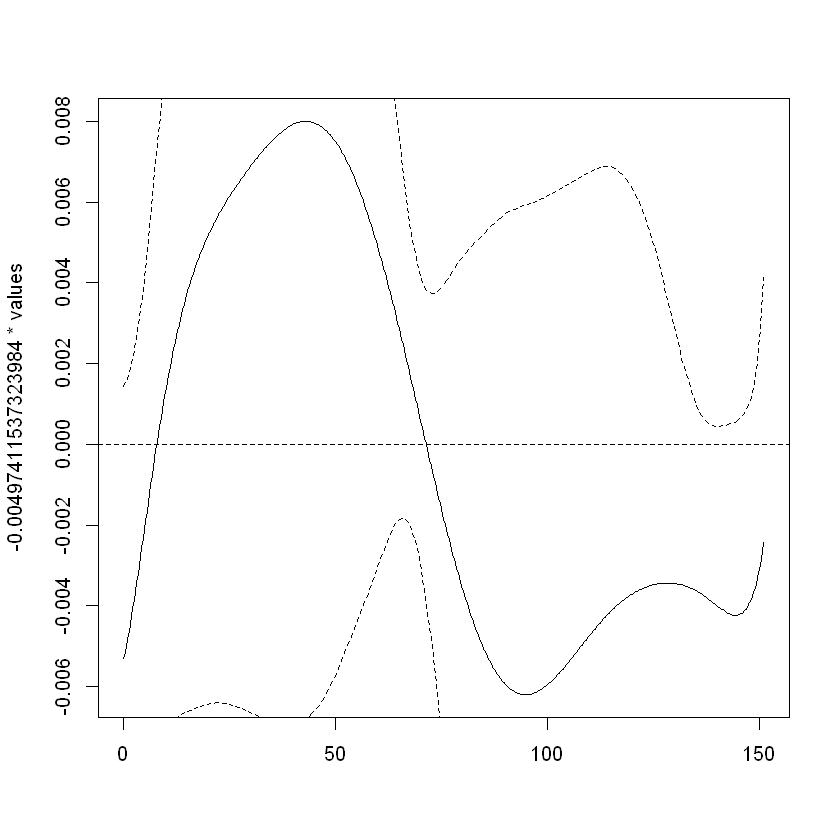

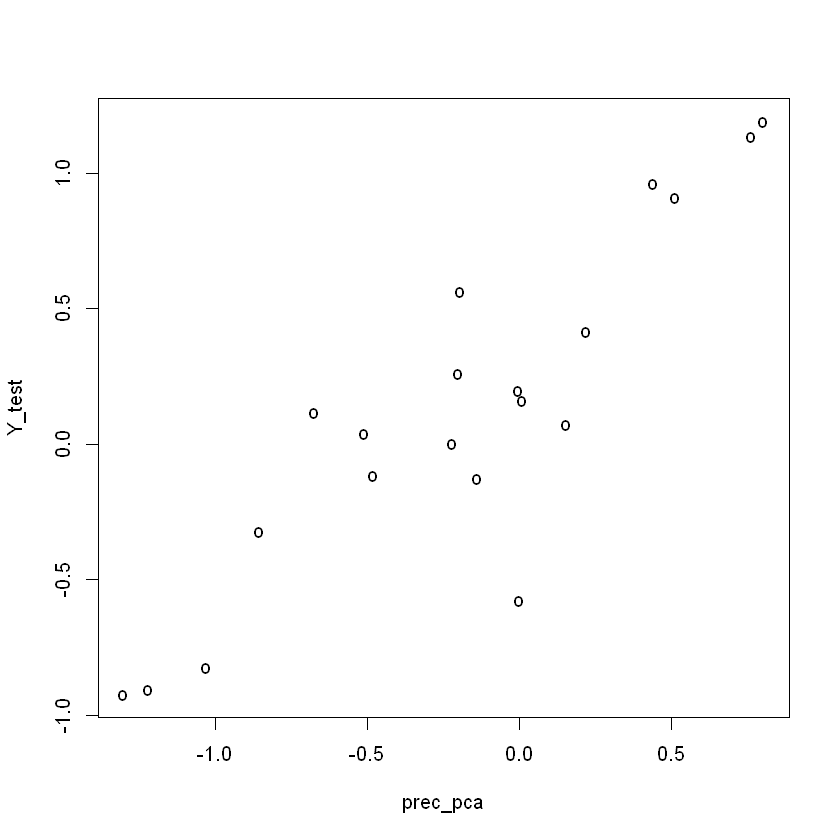

In [9]:
xfdlist = list(const=rep(1, (n_obs-length(test))), smooth_basis=smooth_basis_train_fd)
betabasis1 <- create.constant.basis(c(0, (n_obs-length(test))))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
# here the magic happens!
betafdPar2  <- fdPar(simulated_pcaObj_train$harmonics)
betalist_pca <- list(const=betafdPar1, smooth_basis_fd=betafdPar2)

data = simulated_pcaObj_train$scores
f_regress_pca <- lm(Y_train ~ data)
pca_coeffs = summary(f_regress_pca)$coef
pca_coeffs

betafd = pca_coeffs[2,1]*simulated_pcaObj_train$harmonics[1] +
        pca_coeffs[3,1]*simulated_pcaObj_train$harmonics[2] + 
        pca_coeffs[4,1]*simulated_pcaObj_train$harmonics[3]+ 
        pca_coeffs[5,1]*simulated_pcaObj_train$harmonics[4]


coefvar = pca_coeffs[,2]**2

betavar = (pca_coeffs[2] * simulated_pcaObj_train$harmonics[1])**2 +
          (pca_coeffs[3] * simulated_pcaObj_train$harmonics[2])**2 +
          (pca_coeffs[4] * simulated_pcaObj_train$harmonics[3])**2 + 
          (pca_coeffs[5] * simulated_pcaObj_train$harmonics[4])**2

        #   This all has to become flexible! S.t we can choose the desired components that explain a
        #   certain amount of the variance and then this will become dynamic


plot(betafd)
lines(betafd+2*sqrt(betavar), lty=2, lwd=1)
lines(betafd-2*sqrt(betavar), lty=2, lwd=1)

data = simulated_pcaObj_test$scores
prec_pca <- predict.lm(object = f_regress_pca, data.frame(data = data))

prec_pca2 <- predict(object = f_regress_pca)

MSE_test <
- mean((Y_test-prec_pca)^2)
print(MSE_test)
plot(prec_pca, Y_test, type="p", pch="o")



